# Semantische Themen-Analyse mit LSI/LSA und LDA

## Vorbereitung: Abhängigkeiten installieren

In [83]:
%load_ext autoreload
%autoreload 2

from helpers import *
import sys
import warnings
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
from pprint import pprint
warnings.filterwarnings("ignore", category=DeprecationWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Nur ausführen wenn ohne dev container gearbeitet wird
!{sys.executable} -m pip install -r ../requirements.txt
!{sys.executable} -m spacy download de_core_news_md

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 17.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')


## Schritt 1a: Aktuelle Daten herunterladen
Die Daten werden 1x pro Tag von `https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen` heruntergeladen und im Ordner `../data` abgelegt. Alle folgenden Ausführungen am selben Tag werden exakt diese Daten verwenden.

In [3]:
from datetime import datetime
import os
import requests
import json
import pandas as pd

current_date = datetime.now().strftime("%Y-%m-%d")
dataset_path = f"../data/{current_date}.json"

if os.path.exists(dataset_path):
    print("  Data already downloaded!")
else:
    url = "https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        with open(dataset_path, "w") as f:
            json.dump(data, f)
    else:
        print("  Error: Could not retrieve data from URL")

dataset = pd.read_json(dataset_path, orient="records", typ="series")
dataset = pd.DataFrame(
    map(
        lambda x: {
            "msg_id": x["id"],
            "betreff": x["betreff"],
            "sachverhalt": x["sachverhalt"],
        },
        dataset["index"],
    )
)

dataset.head(10)

  Data already downloaded!


,msg_id,betreff,sachverhalt
0,527563,Sperrmüll abgelagert (Spiegel),Spiegel
1,527575,Sperrmüll abgelagert (Holz-/Regalteile),Holz-/Regalteile
2,622944,Park- und Haltverbot nicht berücksichtigt,Pkw in geschützter Grünanlage aufgefahren
3,681533,Parken auf Gehweg,None
4,788708,Abfall - Müllablagerung,Bauschutt
5,883168,Gehweg/Radweg zugeparkt,None
6,885548,Park- und Haltverbot nicht berücksichtigt,Kfz steht in der kurve. Mit plane abgedeckt.
7,890996,"Parkraumbewirtschaftung - Anwohner-, Gästevign...",ca. 13.22 Uhr\n\nkeine Vignette keine Parksche...
8,950160,Straßenaufsicht - Defekte Ampel,Rotlicht an Ampel K5 komplett erloschen. Ampel...
9,1018325,Parkraumbewirtschaftung - Sonstiges,Seit vier Tagen parkt in falscher Fahrtrichtun...


## Schritt 1b: Visualisierungen für die Rohdaten
Um die Daten ein bisschen besser zu verstehen, helfen bei Texten z.B. Histogramme mit der Textlänge oder der Anzahl Tokens.

array([[<Axes: title={'center': 'length'}>]], dtype=object)

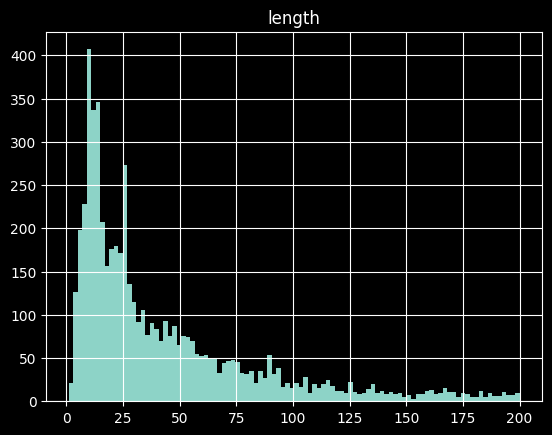

In [4]:
import matplotlib.pyplot as plt
import numpy as np

dataset["length"] = dataset.sachverhalt.astype(str).apply(len)
dataset.hist(column="length", bins=100, range=(1, 200))

Der grösste Teil der Texte ist also kürzer als 100 Zeichen. Um das ein bisschen genauer quantifizieren zu können, berechnen wir ein paar Quantile.

In [5]:
dataset.length.quantile([0.25, 0.5, 0.75, 0.83, 0.9, 0.99])

0.25     14.00
0.50     29.00
0.75     71.00
0.83     99.00
0.90    163.40
0.99    636.24
Name: length, dtype: float64

## Schritt 2: Datensatz aufteilen und Texte vorverarbeiten
In diesem Schritt erstelle ich zuerst 2 verschiedene Datensätze (einen Trainings- und einen Test-Datensatz) mit einer 90/10-Verteilung. Das Test-Set wird am Ende des Notebooks zum Testen der Modelle verwendet.

Die Texte beider Datensätze werden danach wie folgt vorverarbeitet:
* Erstellung von Bi-Grams
* Tokenisierung
* Entfernung von Stopwörtern, Punktuation und Zahlen
* Lemmatisierung
* PoS-Tagging (Part-of-Speech)

array([[<Axes: title={'center': 'count'}>]], dtype=object)

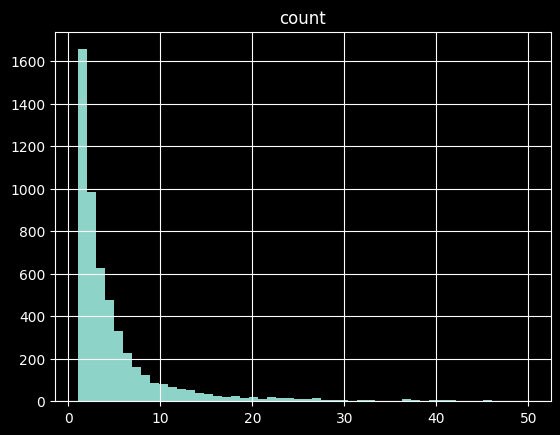

In [77]:
from sklearn.model_selection import train_test_split
import spacy


def get_cleaned_data(df: pd.DataFrame, nlp: spacy.language.Language, use_bigrams=True, prepend_betreff=False):
    if prepend_betreff:
        texts = df.betreff.astype(str) + ' ' + df.sachverhalt.astype(str)
    else:
        texts = df.sachverhalt.astype(str).to_list()
        
    token_ = [text.split(" ") for text in texts if text]

    # construct training tuple
    df_tuple = zip(
        [" ".join(text) for text in token_],
        # set msg_id as context for later reference
        df.msg_id.apply(lambda x: {"msg_id": x}),
    )

    # run pipeline
    docs = list(nlp.pipe(df_tuple, as_tuples=True))

    # extract spacy tokens for filtering
    return extract_spacy_tokens(docs)


def run_text_pipeline(df: pd.DataFrame, nlp: spacy.language.Language, use_bigrams=True, prepend_betreff=False):
    tidy_df = get_cleaned_data(df, nlp, use_bigrams=use_bigrams, prepend_betreff=prepend_betreff)

    # build aggregate
    aggregate = pd.DataFrame(tidy_df.loc[
            # remove short tokens
            tidy_df.lemma.apply(lambda x: len(x) > 2)
            # remove stopwords/punctuations/digits
            & ~tidy_df.is_stop
            & ~tidy_df.is_punct
            & ~tidy_df.is_digit
            # filter numerics
            & tidy_df.pos.apply(lambda x: x != "NUM")
            #& tidy_df.pos.apply(lambda x: x == "NOUN")
        ]
        .groupby(["msg_id"])
        .agg(lambda x: x.values.tolist())
    )
    
    # create bigrams
    if use_bigrams:
        sentences = aggregate.lemma
        bigram = gensim.models.Phrases(sentences, min_count=5, threshold=10)
        bigram_mod = gensim.models.phrases.Phraser(bigram)
        aggregate["tokens"] = [bigram_mod[sentence] for sentence in sentences]
    else:
        aggregate["tokens"] = aggregate.lemma

    return aggregate


# split into training and test set
train_data, test_data = train_test_split(dataset, test_size=0.10, random_state=200)

# define spacy pipeline
nlp = spacy.load(
    "de_core_news_md",
    disable=[
        "textcat",
        "transformer",
        "textcat_multilabel",
        "entity_ruler",
        "attribute_ruler",
    ],
)

# custom stop words
for sw in ["None", "wöchentlich", "Regelmeldung", "14-tägig"]:
    nlp.Defaults.stop_words.add(sw)
    nlp.vocab[sw].is_stop = True

# cleanup sets
training_set = run_text_pipeline(train_data, nlp, prepend_betreff=False)
test_set = run_text_pipeline(test_data, nlp, prepend_betreff=False)

training_set["count"] = training_set['tokens'].apply(len)
test_set["count"] = test_set['tokens'].apply(len)
training_set.hist(column="count", bins=50, range=(1, 50))
#test_set.hist(column="count", bins=50, range=(1, 50))

In [78]:
training_set["count"].quantile([0.25, 0.5, 0.75, 0.83, 0.9, 0.95, 0.99])

0.25     1.0
0.50     3.0
0.75     5.0
0.83     7.0
0.90    11.0
0.95    18.0
0.99    40.0
Name: count, dtype: float64

## Schritt 3: Textvektorisierung mit BoW und TF-IDF
In diesem Abschnitt vergleiche ich die zwei Textvektorisierungs-Methoden Bag-of-Words (BoW) und Term-Frequency Inverse-Document-Frequency (TF-IDF).

### Variante 1: Bag-of-Words

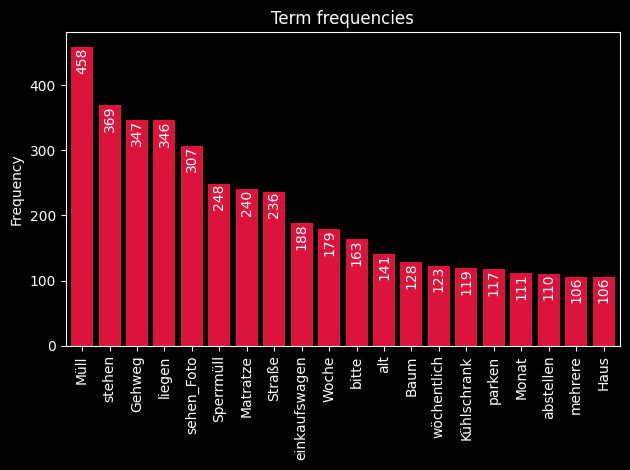

In [79]:
from helpers import get_word_freq, plot_word_freq
from gensim import corpora

# create bag-of-words corpus
bow_dict = corpora.Dictionary()
bow_corpus = [bow_dict.doc2bow(doc, allow_update=True) for doc in training_set.tokens]

word_freq_bow = get_word_freq(bow_corpus, bow_dict)
plot_word_freq(word_freq_bow, 20)

### Variante 2: TF-IDF (Term-Frequency Inverse-Document-Frequency)

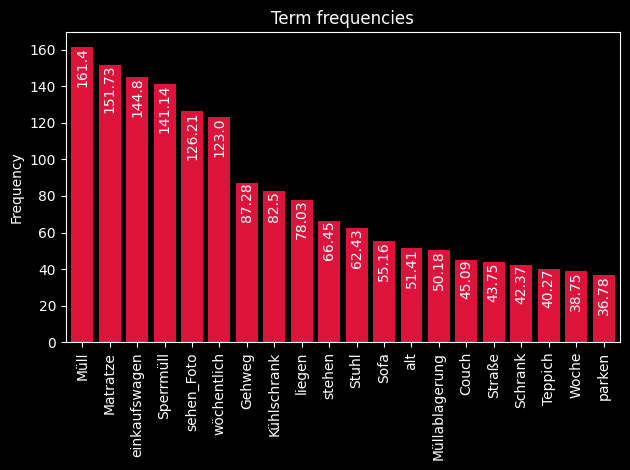

In [81]:
from gensim.models import TfidfModel

# create tf-idf model
tfidf_dict = corpora.Dictionary(training_set.tokens)
tfidf = TfidfModel(dictionary=tfidf_dict, smartirs='ntc')
tfidf_corpus = [tfidf[tfidf_dict.doc2bow(doc)] for doc in training_set.tokens]

# get overall tf-idf scores
word_freq_tfidf = get_word_freq(tfidf_corpus, tfidf_dict)
plot_word_freq(word_freq_tfidf, 20)

## Schritt 4: Modell-Training
Nun werde ich 2 verschiedene Varianten für die Themen-Extraktion vergleichen: Latent Semanting Indexing/Analysis (LSI/LSA) und Latent Dirichlet Allocation (LDA). In einem ersten Schritt werde ich für verschiedene Anzahl Themen (`num_topcs`-Parameter für das `LsiModel` resp. `LdaMulticore`) den Koheränz-Score berechnen und auf einem Diagramm visualisieren. Dies soll mir erlauben, für das spätere Modell-Training die optimale Anzahl Themen zu wählen.

### Variante 1: LSA-Modell trainieren
Zuerst werde ich versuchen, die optimale Anzahl Themenfelder anhand eines Diagramms zu eruieren.

/home/vscode/.local/lib/python3.11/site-packages/gensim/models/lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
/home/vscode/.local/lib/python3.11/site-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
/home/vscode/.local/lib/python3.11/site-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
/home/vscode/.local/lib/python3.11/site-packages/scipy/linalg/_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy

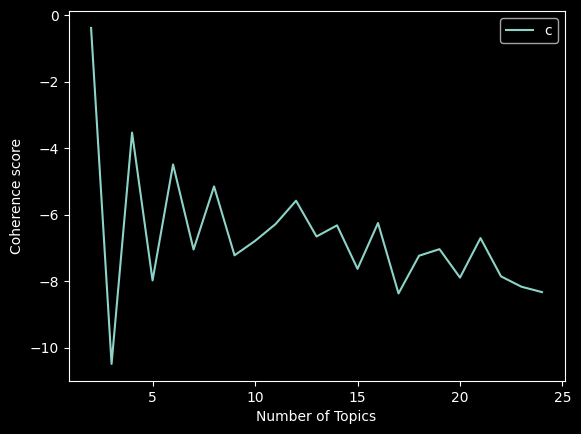

In [82]:
import gensim

# use bow corpus to train LSI model
lsa_dict = gensim.corpora.Dictionary()
lsa_corpus = [lsa_dict.doc2bow(doc, allow_update=True)
              for doc in training_set.tokens]

start, stop, step = 2, 25, 1

_, coherence_values = compute_coherence_values(
    dict=lsa_dict,
    corpus=lsa_corpus,
    training_set=training_set.tokens,
    model_type="lsi",
    coherence="u_mass",
    start=start, stop=stop, step=step
)
plot_coherence_graph(coherence_values, start, stop, step)

Das Diagram zeigt auf, dass die optimale Anzahl Themen zwischen 4 und ca. 8 liegt, mit höheren Werten pendelt sich der Coherence-Score auf einem höheren Niveau ein (wobei bei der `u_mass` Metrik der tiefste Wert der beste ist).

In [84]:
num_topics = 5

lsi_model = LsiModel(lsa_corpus, num_topics=num_topics, id2word=lsa_dict)
topics = get_specific_topics(lsi_model)

for topic_id, terms in topics.items():
    print(f"Topic {topic_id}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")

# Compute Perplexity & Coherence Score
coherence_model_lsa = CoherenceModel(
    model=lsi_model, corpus=lsa_corpus, dictionary=lsa_dict, coherence="u_mass"
)
coherence_lsa = coherence_model_lsa.get_coherence()
print("Coherence Score: ", coherence_lsa)

Topic 0:
  knallen: -0.4385
  klopf_Geräusch: -0.3486
  aufeinander_knallen: -0.3196
  Maschine: -0.2913
  Bodenwisch: -0.2905
Topic 1:
  Gehweg: -0.3901
  Müll: -0.3241
  stehen: -0.2598
  liegen: -0.2373
  Straße: -0.2164
Topic 2:
  Müll: -0.4970
  Gehweg: 0.3892
  Foto: -0.1778
  stehen: 0.1696
  Haus: -0.1582
Topic 3:
  Gehweg: 0.3974
  Straße: -0.3057
  stehen: -0.2699
  
 
: -0.1539
  Mülltonne: -0.1515
Topic 4:
  stehen: 0.3966
  sehen_Foto: 0.3453
  liegen: 0.3187
  
 
: -0.1924
  Rückmeldung: -0.1891
Coherence Score:  -7.278446125211351


## Variante 2: LDA-Modell trainieren
Als zweite Variante trainiere ich mit den Daten ein LDA-Modell (Latent Dirichlet Allocation) zur Ermittlung der Top-Themen in den Daten. Auch hier soll in einem ersten Schritt die ideale Anzahl Themen anhand des Coherence-Scores ermittelt werden (dieses Mal auf Basis des `LdaMulticore`-Modells).

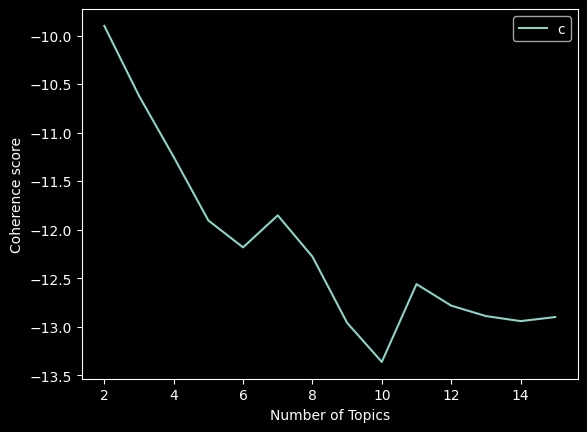

In [93]:
import gensim

alpha = 0.01
eta = 0.5
gamma = 0.001
max_topcs = 15

lda_dict = gensim.corpora.Dictionary()
lda_corpus = [lda_dict.doc2bow(doc, allow_update=True)
              for doc in training_set.tokens]

start, stop, step = 2, max_topcs + 1, 1
_, coherence_values = compute_coherence_values(
    dict=lda_dict,
    corpus=lda_corpus,
    training_set=training_set.tokens,
    coherence="u_mass",
    model_type="lda",
    alpha=alpha, eta=eta, gamma=gamma,
    start=start, stop=stop, step=step
)
plot_coherence_graph(coherence_values, start, stop, step)

Bei LDA zeigt sich zum einen eine tiefere Varianz in der Koheränz und zum anderen eine Verschiebung hin zu mehr Themenfelder. Wir trainieren das LDA-Modell mit ca. 10 Themenfeldern und visualisieren die Resultate mit dem Python-Paket `pyLDAvis`, zur Evaluation wird wieder der Coherence-Score herangezogen.

In [94]:
from gensim.models import CoherenceModel, LdaMulticore
import pyLDAvis.gensim_models

num_topics = 10

# train model
lda_model = LdaMulticore(
    lda_corpus,
    num_topics=num_topics,
    id2word=lda_dict,
    passes=1,
    chunksize=1000,
    iterations=100,
    workers=5,
    random_state=200,
    alpha=alpha, eta=eta, gamma_threshold=gamma,
)

# Compute Perplexity & Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, corpus=lda_corpus, texts=training_set.tokens, dictionary=lda_dict, coherence="u_mass"
)
coherence_lda = coherence_model_lda.get_coherence()
print("Perplexity: ", lda_model.log_perplexity(lda_corpus))
print("Coherence Score: ", coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, lda_corpus, lda_dict, sort_topics=False, mds='tsne')
pyLDAvis.display(vis)

Perplexity:  -8.614599627412638
Coherence Score:  -8.838964651440595


# Schritt 5a: LSI-Modell evaluieren
Anhand des Test-Sets und der zugewiesenen Kategorien im Feld `betreff` werden wir nun prüfen, wie genau die Einordnungen des LSI-Modells sind.

In [87]:
lsi_test_dict = gensim.corpora.Dictionary()
lsi_test_corpus = [lsi_test_dict.doc2bow(doc, allow_update=True)
                   for doc in test_set.tokens]

predictions = lsi_model[lsi_test_corpus]

dfs = []
for i, preds in enumerate(predictions):
    doc = test_set.iloc[i]
    msg_id = doc.name

    # get original subject/text from source data
    subject = test_data[test_data.msg_id == msg_id].betreff.values[0]
    text = test_data[test_data.msg_id == msg_id].sachverhalt.values[0]

    # sort topics by score, get top topic and its top 5 terms
    preds.sort(key=lambda x: x[1], reverse=True)
    topic_id, _ = preds[0]
    top_terms = [topic[0] for topic in lsi_model.show_topic(topic_id, 5)[:]]

    doc_df = pd.DataFrame(
        [(msg_id, subject, text, topic_id, top_terms)],
        columns=["msg_id", "subject", "text", "topic_id", "top_terms"],
    )
    dfs.append(doc_df)

df = pd.concat(dfs)
df.head(20)

,msg_id,subject,text,topic_id,top_terms
0,950160,Straßenaufsicht - Defekte Ampel,Rotlicht an Ampel K5 komplett erloschen. Ampel...,4,"[stehen, sehen_Foto, liegen, \n \n, Rückmeldung]"
0,1879786,Bauabfälle abgelagert,Bauabfälle,4,"[stehen, sehen_Foto, liegen, \n \n, Rückmeldung]"
0,1952812,Müllablagerung,"Speisereste, Glas",2,"[Müll, Gehweg, Foto, stehen, Haus]"
0,2064478,Abfall - Müllablagerung,Überquellender und verdreckter Altkleiderconta...,2,"[Müll, Gehweg, Foto, stehen, Haus]"
0,2074824,Abfall - Sonstiges,Kleinverschmutzungen,2,"[Müll, Gehweg, Foto, stehen, Haus]"
0,2173627,Elektroschrott abgelagert,4x Altreifen,2,"[Müll, Gehweg, Foto, stehen, Haus]"
0,2305087,Müllablagerung,"Essensreste, Mülltüten",2,"[Müll, Gehweg, Foto, stehen, Haus]"
0,2346871,Sperrmüll abgelagert,Sperrmüll,4,"[stehen, sehen_Foto, liegen, \n \n, Rückmeldung]"
0,2851983,Lärm - Gaststätte,\n6:20 uhr ( Nachtruhestörung)hochstellen von ...,2,"[Müll, Gehweg, Foto, stehen, Haus]"
0,3755787,Campieren,"Drogensüchtige Person, nächtigt seit Tagen an ...",4,"[stehen, sehen_Foto, liegen, \n \n, Rückmeldung]"


# Schritt 5: LDA-Modell evaluieren
Anhand des Test-Sets und der zugewiesenen Kategorien im Feld `betreff` werden wir nun prüfen, wie genau die Einordnungen des Modells sind.

In [88]:
lda_test_dict = gensim.corpora.Dictionary()
lda_test_corpus = [lda_test_dict.doc2bow(doc, allow_update=True)
              for doc in test_set.tokens]

predictions = lda_model.get_document_topics(lda_test_corpus)

dfs = []
for i, preds in enumerate(predictions):
    doc = test_set.iloc[i]
    msg_id = doc.name

    # get original subject/text from source data
    subject = test_data[test_data.msg_id == msg_id].betreff.values[0]
    text = test_data[test_data.msg_id == msg_id].sachverhalt.values[0]

    # sort topics by score, get top topic and its top 5 terms
    preds.sort(key=lambda x: x[1], reverse=True)
    topic_id, probability = preds[0]
    top_terms = [topic[0] for topic in lda_model.show_topic(topic_id, 5)[:]]

    doc_df = pd.DataFrame(
        [(msg_id, subject, text, topic_id, top_terms, probability)],
        columns=["msg_id", "subject", "text", "topic_id", "top_terms", "probability"],
    )
    dfs.append(doc_df)

df = pd.concat(dfs)
df.head(20)

,msg_id,subject,text,topic_id,top_terms,probability
0,950160,Straßenaufsicht - Defekte Ampel,Rotlicht an Ampel K5 komplett erloschen. Ampel...,11,"[Müll, stehen, liegen, Mülltonne, Haus]",0.538472
0,1879786,Bauabfälle abgelagert,Bauabfälle,10,"[stehen, Straße, sehen_Foto, Fahrrad, Sperrmüll]",0.878259
0,1952812,Müllablagerung,"Speisereste, Glas",10,"[stehen, Straße, sehen_Foto, Fahrrad, Sperrmüll]",0.934852
0,2064478,Abfall - Müllablagerung,Überquellender und verdreckter Altkleiderconta...,8,"[stehen, Kühlschrank, liegen, Woche, Gehweg]",0.955540
0,2074824,Abfall - Sonstiges,Kleinverschmutzungen,13,"[Gehweg, liegen, Müll, sehen_Foto, stehen]",0.878240
0,2173627,Elektroschrott abgelagert,4x Altreifen,4,"[Gehweg, Straße, Matratze, liegen, Auto]",0.878222
0,2305087,Müllablagerung,"Essensreste, Mülltüten",9,"[stehen, Straße, Monat, Müll, liegen]",0.934874
0,2346871,Sperrmüll abgelagert,Sperrmüll,9,"[stehen, Straße, Monat, Müll, liegen]",0.878256
0,2851983,Lärm - Gaststätte,\n6:20 uhr ( Nachtruhestörung)hochstellen von ...,13,"[Gehweg, liegen, Müll, sehen_Foto, stehen]",0.493233
0,3755787,Campieren,"Drogensüchtige Person, nächtigt seit Tagen an ...",8,"[stehen, Kühlschrank, liegen, Woche, Gehweg]",0.966248


array([[<Axes: title={'center': 'probability'}>]], dtype=object)

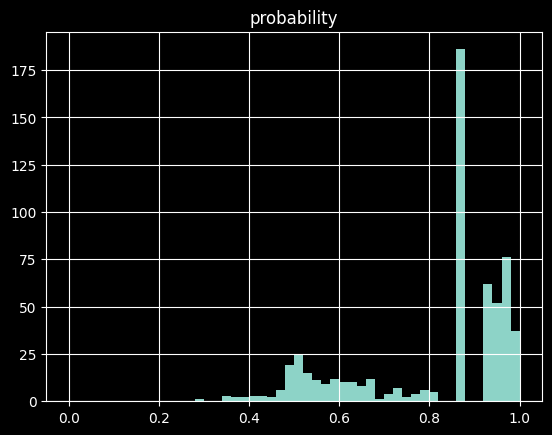

In [89]:
df.hist(column="probability", bins=50, range=(0, 1))